## IMPORT

In [1]:
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display_html
import numpy as np

## PATH

In [2]:
ROOT = Path.cwd().parent

data_path = ROOT / 'data'

## LOAD DATA

In [3]:
data_long = pd.read_csv(data_path / 'Regions_to_USA.csv')

In [4]:
df = data_long.pivot(index='month', columns='region', values='export_value').reset_index()

In [5]:
df['month'] = pd.to_datetime(df['month'])

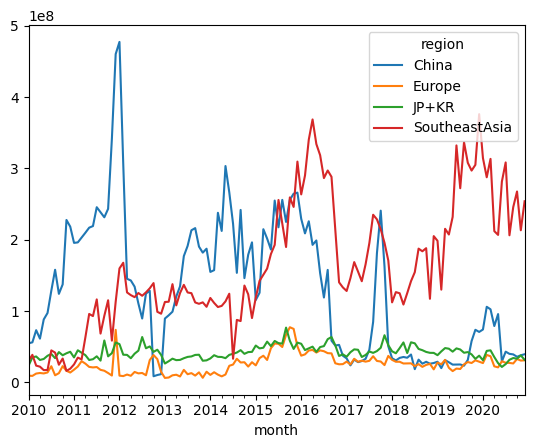

In [6]:
df.set_index('month').plot()
plt.show()

In [7]:
total_exports = df.set_index('month').sum().sort_values(ascending=False)
top_3_countries = total_exports.head(3).index.tolist()
print(top_3_countries)

['SoutheastAsia', 'China', 'JP+KR']


## LOTKA VOLTERRA BASICO

In [8]:
df = df.set_index('month')

In [9]:
# Fill missing values (optional)
df = df.fillna(method='ffill').fillna(method='bfill')

# Normalize (optional but helps with scaling)
# df = df / df.max()

# Log (no assumption)
df = np.log(df)

C:\Users\Leonardo\AppData\Local\Temp\ipykernel_13860\3559439876.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [10]:
df

region,China,Europe,JP+KR,SoutheastAsia
month,,,,
2010-01-01,17.820282,16.062687,16.976173,17.237856
2010-02-01,17.844260,16.027689,17.374071,17.470379
2010-03-01,18.109026,16.333649,17.408936,16.973071
2010-04-01,17.932573,16.396135,17.264531,16.909982
2010-05-01,18.296227,16.348227,17.308055,16.662269
...,...,...,...,...
2020-08-01,17.505551,17.123346,17.272366,19.144872
2020-09-01,17.486326,17.095225,17.347827,19.320225
2020-10-01,17.395848,17.306808,17.318720,19.405283


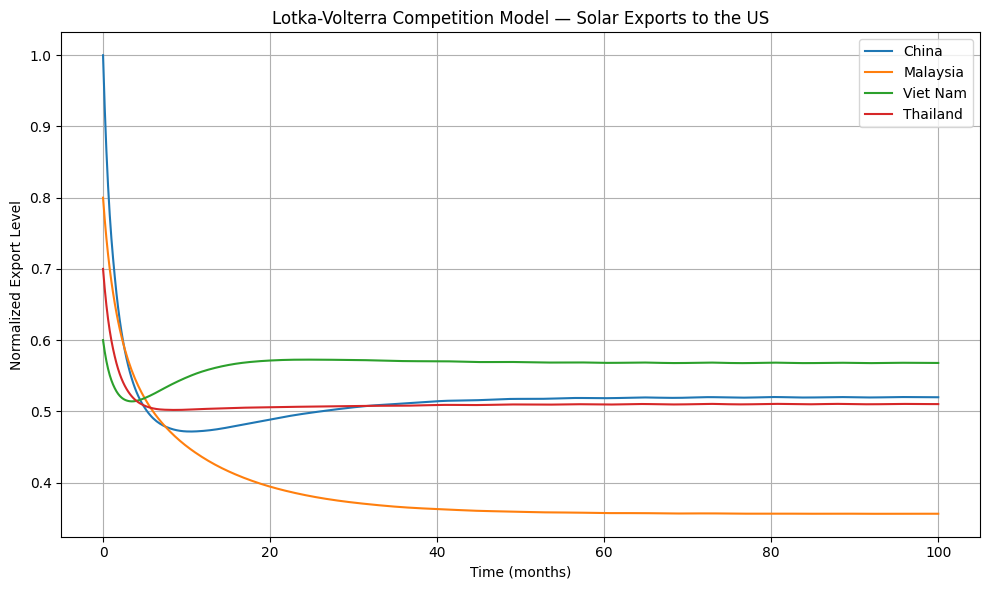

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def lotka_volterra_4_explicit(t, X, r1, r2, r3, r4,
                               a11, a12, a13, a14,
                               a21, a22, a23, a24,
                               a31, a32, a33, a34,
                               a41, a42, a43, a44):
    x1, x2, x3, x4 = X

    dx1dt = r1 * x1 * (1 - a11 * x1 - a12 * x2 - a13 * x3 - a14 * x4)
    dx2dt = r2 * x2 * (1 - a21 * x1 - a22 * x2 - a23 * x3 - a24 * x4)
    dx3dt = r3 * x3 * (1 - a31 * x1 - a32 * x2 - a33 * x3 - a34 * x4)
    dx4dt = r4 * x4 * (1 - a41 * x1 - a42 * x2 - a43 * x3 - a44 * x4)

    return [dx1dt, dx2dt, dx3dt, dx4dt]

# Parameters
params = {
    'r1': 0.5, 'r2': 0.3, 'r3': 0.4, 'r4': 0.45,
    'a11': 1.0, 'a12': 0.6, 'a13': 0.2, 'a14': 0.3,
    'a21': 0.3, 'a22': 1.0, 'a23': 0.5, 'a24': 0.4,
    'a31': 0.4, 'a32': 0.2, 'a33': 1.0, 'a34': 0.3,
    'a41': 0.3, 'a42': 0.3, 'a43': 0.4, 'a44': 1.0
}

# Initial conditions
X0 = [1.0, 0.8, 0.6, 0.7]  # China, Malaysia, Viet Nam, new exporter (e.g., Thailand)

# Time span and evaluation points
t_span = (0, 100)
t_eval = np.linspace(*t_span, 500)

# Solve the system
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_4_explicit(t, X, **params),
    t_span=t_span,
    y0=X0,
    t_eval=t_eval,
    method='RK45'
)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='China')
plt.plot(sol.t, sol.y[1], label='Malaysia')
plt.plot(sol.t, sol.y[2], label='Viet Nam')
plt.plot(sol.t, sol.y[3], label='Thailand')  # Replace with desired country
plt.title('Lotka-Volterra Competition Model — Solar Exports to the US')
plt.xlabel('Time (months)')
plt.ylabel('Normalized Export Level')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
df

region,China,Europe,JP+KR,SoutheastAsia
month,,,,
2010-01-01,17.820282,16.062687,16.976173,17.237856
2010-02-01,17.844260,16.027689,17.374071,17.470379
2010-03-01,18.109026,16.333649,17.408936,16.973071
2010-04-01,17.932573,16.396135,17.264531,16.909982
2010-05-01,18.296227,16.348227,17.308055,16.662269
...,...,...,...,...
2020-08-01,17.505551,17.123346,17.272366,19.144872
2020-09-01,17.486326,17.095225,17.347827,19.320225
2020-10-01,17.395848,17.306808,17.318720,19.405283


## CALIBRATION

In [13]:
from scipy.optimize import least_squares

china_data = df['China']
europe_data = df['Europe']
jp_kr_data = df['JP+KR']
se_data = df['SoutheastAsia']

# Stack data for comparison
data = np.vstack([china_data, europe_data, jp_kr_data, se_data])  # shape (3, T)
t_data = np.linspace(0, len(china_data)-1, len(china_data))  # e.g. months

In [14]:
def residuals(params, X0, t_data, data):
    # Unpack parameters
    r1, r2, r3, r4 = params[:4]
    a11, a12, a13, a14 = params[4:8]
    a21, a22, a23, a24 = params[8:12]
    a31, a32, a33, a34 = params[12:16]
    a41, a42, a43, a44 = params[16:]

    # Solve the system
    sol = solve_ivp(
        fun=lambda t, X: lotka_volterra_4_explicit(t, X,
                                                   r1, r2, r3, r4,
                                                   a11, a12, a13, a14,
                                                   a21, a22, a23, a24,
                                                   a31, a32, a33, a34,
                                                   a41, a42, a43, a44),
        t_span=(t_data[0], t_data[-1]),
        y0=X0,
        t_eval=t_data,
        method='RK45'
    )

    # Check for integration failure
    if sol.y.shape[1] != len(t_data):
        return np.ones(data.size) * 1e6

    # Return flattened residuals
    return (sol.y - data).ravel()


In [15]:
from scipy.optimize import least_squares

# Initial guess for 4 species: r1–r4, a11–a44 (row-wise)
initial_guess = [
    0.5, 0.3, 0.4, 0.35,        # r1, r2, r3, r4
    1.0, 0.6, 0.2, 0.1,         # a11, a12, a13, a14
    0.3, 1.0, 0.5, 0.2,         # a21, a22, a23, a24
    0.4, 0.2, 1.0, 0.3,         # a31, a32, a33, a34
    0.2, 0.4, 0.3, 1.0          # a41, a42, a43, a44
]

# Initial export levels from your data (must be shape (4,))
X0 = data[:, 0]

# Bounds (e.g., positive parameters only, up to 10)
lower_bounds = [0] * 20
upper_bounds = [10] * 20

# Fit the model to data
result = least_squares(
    residuals,
    initial_guess,
    args=(X0, t_data, data),
    bounds=(lower_bounds, upper_bounds)
)

# Extract fitted parameters
fitted_params = result.x


In [16]:
fitted_params

array([5.61164273e-01, 3.36287005e-01, 1.46795078e-01, 6.68532622e-02,
       4.53667766e-03, 1.68879962e-02, 3.56448434e-02, 3.15297416e-04,
       7.70002698e-23, 8.61050601e-03, 4.86697581e-02, 2.67612346e-16,
       6.28462968e-03, 2.19319357e-25, 3.65919371e-02, 1.29357900e-02,
       1.23536879e-02, 2.21141129e-02, 2.77256945e-08, 2.05160067e-02])

<Axes: xlabel='month'>

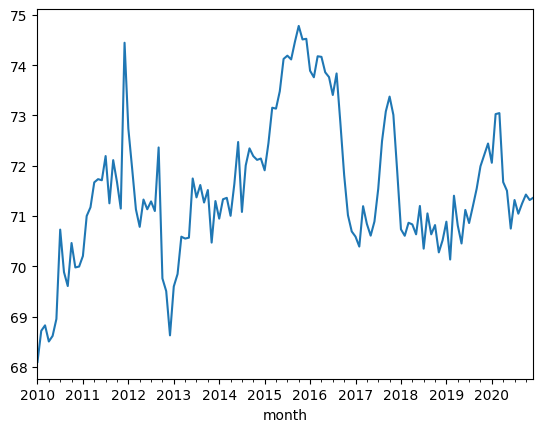

In [17]:
df.sum(axis = 1).plot()

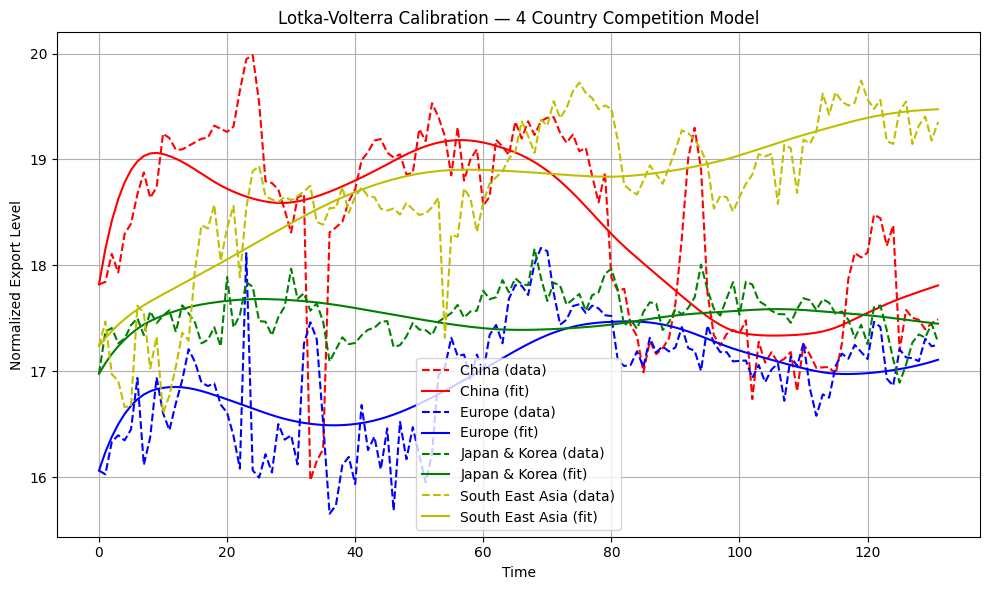

In [18]:
# Solve the system using the fitted parameters
sol = solve_ivp(
    fun=lambda t, X: lotka_volterra_4_explicit(t, X, *fitted_params),
    t_span=(t_data[0], t_data[-1]),
    y0=X0,
    t_eval=t_data
)

# Plot results: data vs. model for all 4 countries
plt.figure(figsize=(10, 6))
colors = ['r', 'b', 'g', 'y']
labels = ['China', 'Europe', 'Japan & Korea', 'South East Asia']  # update names if needed

for i in range(4):
    plt.plot(t_data, data[i], f'{colors[i]}--', label=f'{labels[i]} (data)')
    plt.plot(t_data, sol.y[i], f'{colors[i]}-', label=f'{labels[i]} (fit)')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Normalized Export Level')
plt.title('Lotka-Volterra Calibration — 4 Country Competition Model')
plt.grid(True)
plt.tight_layout()
plt.show()
